In [1]:
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
from data import open_sample
from alaw import alaw_compress, alaw_expand

## Test A-law compress/decompress

In [3]:
N = 32768
np.random.seed(42)
x_orig = np.random.randint(0, 32767, size=N, dtype=np.uint16)
x_compressed = alaw_compress(x_orig)
x_decompressed = alaw_expand(x_compressed)

max_diff = np.max(np.abs(np.int32(x_orig) - np.int32(x_decompressed)))
print("Maximum absolute difference after compression: %d" % max_diff)
assert (max_diff <= 256)

Maximum absolute difference after compression: 256


## Verilog A-law compression demo

### Open data

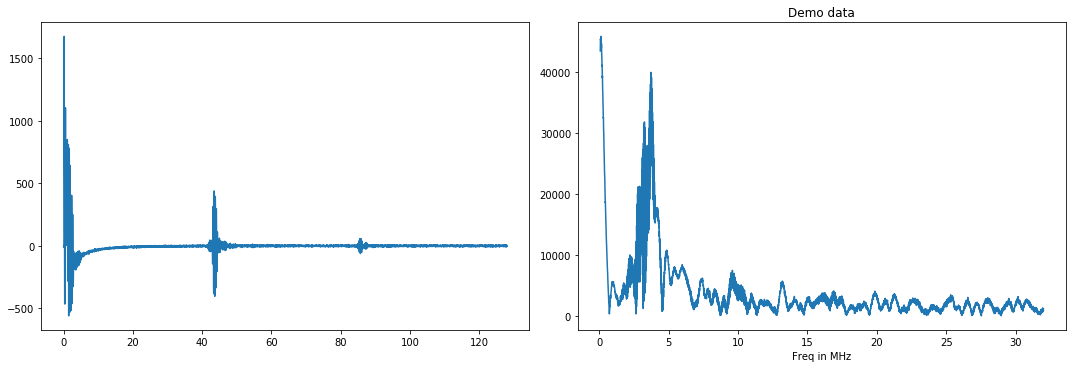

In [4]:
RES = open_sample()
n = len(RES)
tRaw = [x/64.0 for x in range(n)]
Nmax = int(n/2)
f = [x*64.0/n for x in range(n)]
FFT = np.fft.fft(RES)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(tRaw, RES)
plt.xlabel('Time in microseconds')

axes[1].plot(f[10:Nmax], np.abs(FFT)[10:Nmax])
plt.xlabel('Freq in MHz')

fig.tight_layout()
plt.title("Demo data")
plt.show()

###  NumPy envelope extraction

In [5]:
def env256_np(data):
    n = len(data)
    N = 256
    fDebut = 1
    widthFreqWindow = 3
    w = int(n/N)
    envSeg = []
    tSeg = [x*128.0/N for x in range(N)]

    for k in range(N):
        FFT = np.fft.fft(data[(k*w):(((k+1)*w))])
        envSeg.append(0.125*0.5*np.sum(np.abs(FFT[fDebut:fDebut+widthFreqWindow])))
    return envSeg
scale_factor = 30
env256_np_seg = scale_factor * np.array(env256_np(RES), dtype=np.uint16)
RES_Scaled = scale_factor*1.5*np.array(RES)
tRaw_scaled = np.array(tRaw) - 0.25
N=256
tSeg = [x*128.0/N for x in range(N)]

Text(0.5, 1.0, '')

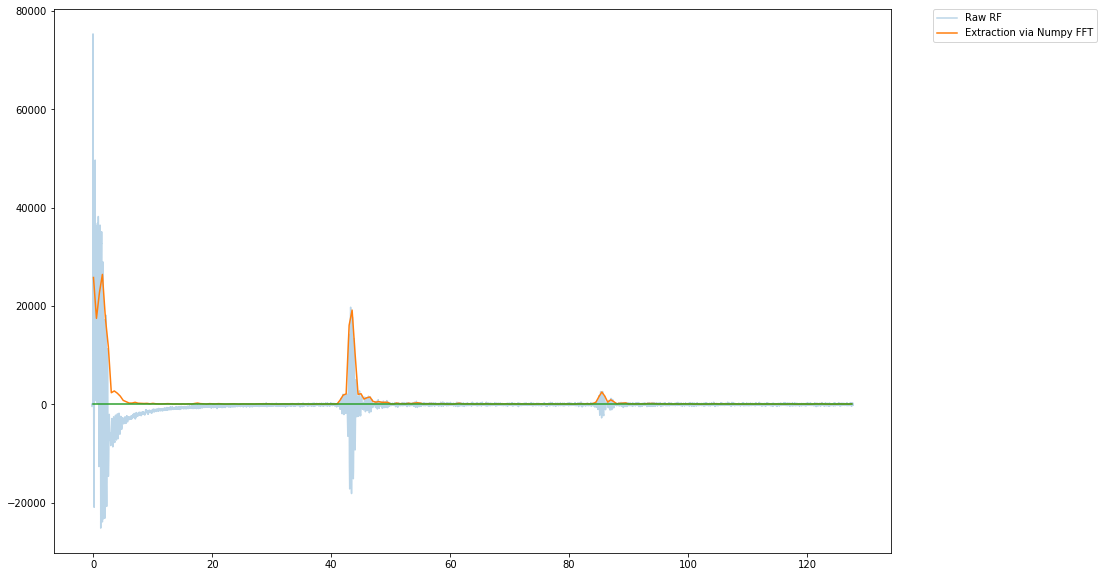

In [6]:
plt.figure(figsize=(15, 10))
plt.plot(tRaw_scaled, RES_Scaled, label='Raw RF', alpha=0.3)
plt.plot(tSeg, (env256_np_seg), label='Extraction via Numpy FFT')
plt.title("Enveloppe extraction")
plt.plot(tSeg, np.zeros(len(tSeg)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("")

### A-law Python envelope compression

In [7]:
env256_alaw_py_compressed = alaw_compress(env256_np_seg)
env256_alaw_py_decompressed = alaw_expand(env256_alaw_py_compressed)

max_diff = np.max(np.abs(np.int32(env256_np_seg) - np.int32(env256_alaw_py_decompressed)))
print("Maximum difference after compression: %d" % max_diff)
assert (max_diff <= 256)

Maximum difference after compression: 174


### Other implementation of A-law compression

In [8]:
def luc_lawAcompress(signal):
    compressed = []
    for k in signal:
        compressed.append(applyLaw(k))
    return compressed

def applyLaw(n):
    val = -1
    for k in range(7):
        if n >> (11-k):
            val = 1 
            reste = n - 2**(11-k)
            mantisse = bin(int(bin(reste)[:7],2))
            resultat = (7-k)*(2**5) + int(mantisse,2)
            #print(bin(n),val,k,  mantisse, bin(resultat),resultat ) 
            return int(resultat)
    resultat = int(bin(n)[:7],2)
    #print(bin(n),bin(resultat)) 
    return int(resultat)

env256_luc_alaw_compressed = np.array(luc_lawAcompress(env256_np_seg))

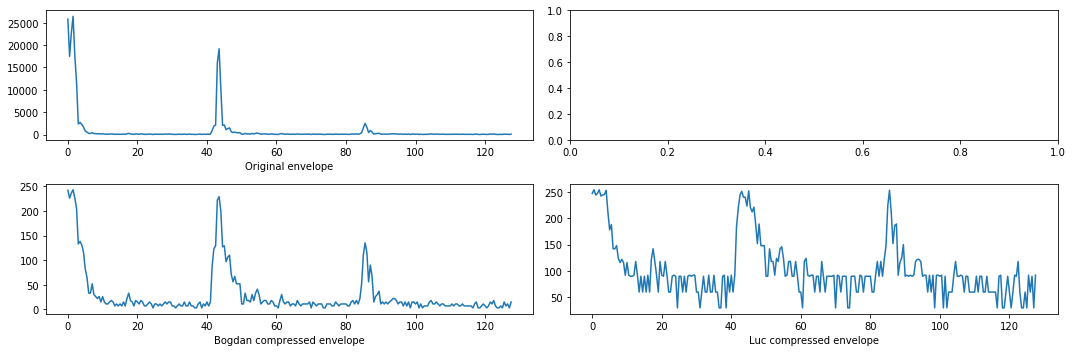

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
axes[0,0].plot(tSeg, env256_np_seg)
axes[0,0].set_xlabel('Original envelope')
axes[1,0].plot(tSeg, env256_alaw_py_compressed)
axes[1,0].set_xlabel('Bogdan compressed envelope')
axes[1,1].plot(tSeg, env256_luc_alaw_compressed)
axes[1,1].set_xlabel('Luc compressed envelope')
fig.tight_layout()
plt.show()

### A-law Verilog envelope compression

In [10]:
def open_verilog_demo_out(filename='../sim/tb/tb_demo_out.mem'):
    with open(filename) as mem_file:
        raw_lines = mem_file.readlines()
    data = [int(i, 16) for i in raw_lines if "//" not in i]
    return data
        
env256_alaw_vlog_compressed = open_verilog_demo_out()
env256_alaw_vlog_decompressed = alaw_expand(env256_alaw_vlog_compressed)

print("Python and Verilog compression models are equal:", np.allclose(env256_alaw_vlog_decompressed, env256_alaw_py_decompressed))

Python and Verilog compression models are equal: True


### Decompressed with the original compare

Text(0.5, 1.0, 'Envelope decompression test')

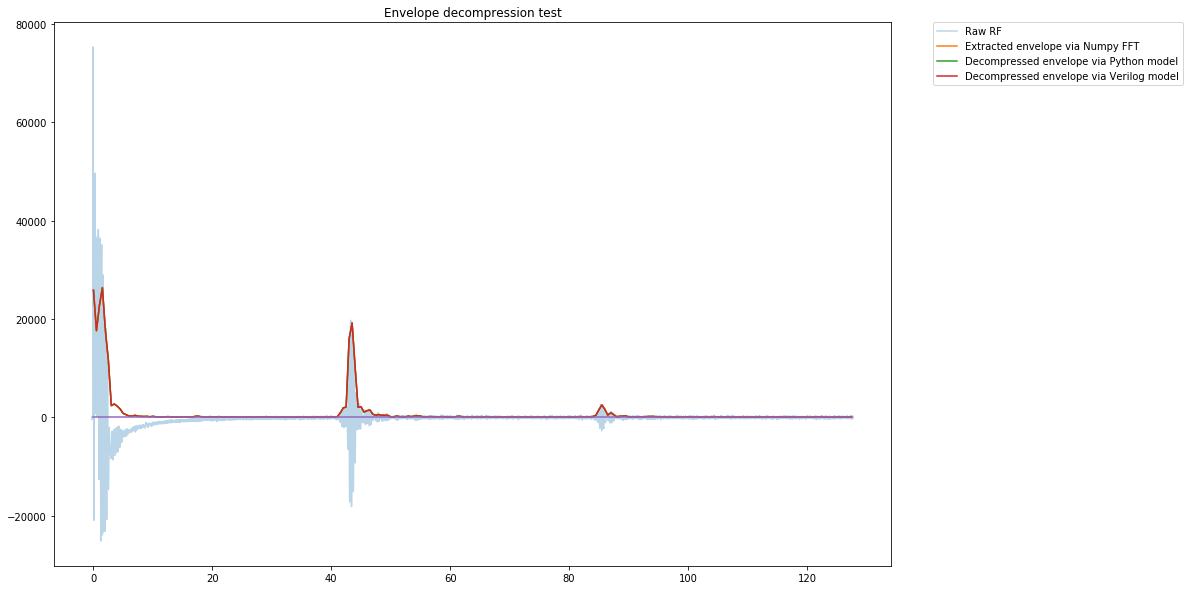

In [11]:
plt.figure(figsize=(15, 10))
plt.plot(tRaw_scaled, RES_Scaled, label='Raw RF', alpha=0.3)
plt.plot(tSeg, (env256_np_seg), label='Extracted envelope via Numpy FFT')
plt.plot(tSeg, (env256_alaw_py_decompressed), label='Decompressed envelope via Python model')
plt.plot(tSeg, (env256_alaw_vlog_decompressed), label='Decompressed envelope via Verilog model')
plt.plot(tSeg, np.zeros(len(tSeg)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Envelope decompression test")

(-50, 21000)

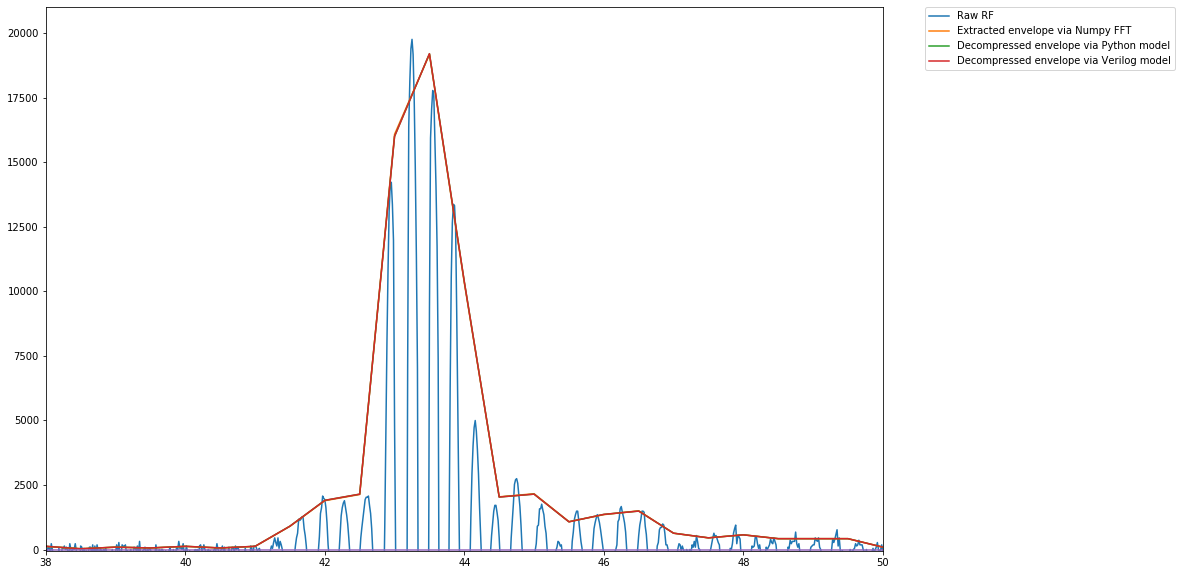

In [12]:
plt.figure(figsize=(15, 10))

plt.plot(tRaw_scaled, RES_Scaled, label='Raw RF')
plt.plot(tSeg, (env256_np_seg), label='Extracted envelope via Numpy FFT')
plt.plot(tSeg, (env256_alaw_py_decompressed), label='Decompressed envelope via Python model')
plt.plot(tSeg, (env256_alaw_vlog_decompressed), label='Decompressed envelope via Verilog model')
plt.plot(tSeg, np.zeros(len(tSeg)))
plt.title("Envelope decompression test")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("")
plt.xlim(38, 50)
plt.ylim(-50, scale_factor*700)

(-10, 3600)

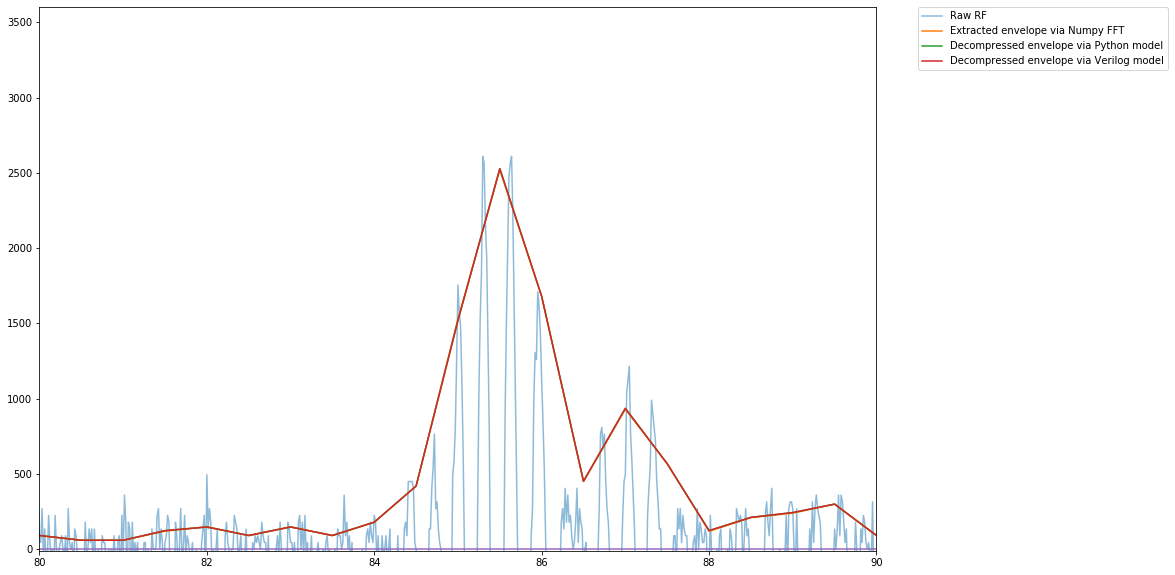

In [13]:
plt.figure(figsize=(15, 10))
plt.plot(tRaw_scaled, RES_Scaled, label='Raw RF', alpha=0.5)
plt.plot(tSeg, (env256_np_seg), label='Extracted envelope via Numpy FFT')
plt.plot(tSeg, (env256_alaw_py_decompressed), label='Decompressed envelope via Python model')
plt.plot(tSeg, (env256_alaw_vlog_decompressed), label='Decompressed envelope via Verilog model')
plt.plot(tSeg, np.zeros(len(tSeg)))
plt.title("Envelope decompression test")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("")
plt.xlim(80, 90)
plt.ylim(-10, scale_factor*2*60)

## File generation for testbenches

### tb_alaw_coder

In [14]:
N = 16384
np.random.seed(42)
x = np.random.randint(0, 32767, size=N, dtype=np.uint16)

alaw_res = alaw_compress(x)

with open('../sim/tb/tb_alaw_coder_in.mem', 'w') as mem_file:
    for val in x:
        mem_file.write('%s\n' % str(hex(val & 0x7FFF))[2:])

with open('../sim/tb/tb_alaw_coder_out.mem', 'w') as mem_file:
    for val in alaw_res:
            mem_file.write('%s\n' % str(hex(val & 0xFF))[2:])

### tb_demo

In [15]:
with open('../sim/tb/tb_demo_in.mem', 'w') as mem_file:
    for val in env256_np_seg:
        mem_file.write('%s\n' % str(hex(val & 0x7FFF))[2:])